In [ ]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
import os
import math
import string

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.backend import get_value, ctc_decode
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(tf.__version__)

2.15.0


# Разделение выборки на обучающую и тестовую

In [ ]:
def labelToNum(label, alphabet):
  labelNum = []
  for ch in label:
    labelNum.append(alphabet.find(ch))
  return np.array(labelNum)

In [ ]:
def encodeText(texts):
  tempChars = []
  for i in range(0, len(texts)):
    for j in range(0, len(texts[i])):
      if not texts[i][j] in tempChars:
        tempChars.append(texts[i][j])

  alphabet = ''.join(sorted(tempChars))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = labelToNum(text, alphabet)
  return nums, alphabet

In [ ]:
filesPath = "/content/drive/MyDrive/Colab Notebooks/OCR наброски"
train_X = np.load("%s/train_X.npy" % filesPath, allow_pickle=True)
train_y = np.load("%s/train_y.npy" % filesPath, allow_pickle=True)
print(train_y[0])

8oy4777 l-R-W#1' UqBHjO


In [ ]:
train_y, alphabet = encodeText(train_y)
print(alphabet)
print(train_y[0])

 !"#$%&'()*+,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё
[ 24  76  86  20  23  23  23   0  73  13  47  13  52   3  17   7   0  50
  78  31  37  71  44 157 157 157 157 157 157 157 157 157 157 157 157 157
 157 157 157 157 157 157 157 157 157 157 157 157 157 157 157 157 157 157
 157 157 157]


In [ ]:
train_X, val_X, train_y, val_y  = train_test_split(train_X, train_y, test_size=0.2, random_state=44)
train_X, test_X, train_y, test_y  = train_test_split(train_X, train_y, test_size=0.15, random_state=44)

np.save("%s/OCRdata/train_X.npy" % filesPath, train_X)
np.save("%s/OCRdata/train_y.npy" % filesPath, train_y)
np.save("%s/OCRdata/test_X.npy" % filesPath, test_X)
np.save("%s/OCRdata/test_y.npy" % filesPath, test_y)
np.save("%s/OCRdata/val_X.npy" % filesPath, val_X)
np.save("%s/OCRdata/val_y.npy" % filesPath, val_y)

# Загрузка выборки

In [ ]:
filesPath = "/content/drive/MyDrive/Colab Notebooks/OCR наброски"
with open("%s/OCRdata/alphabet.txt" % filesPath, 'r') as file:
    alphabet = file.read().replace('\n', '')
print(alphabet)

 !"#$%&'()*+,-./0123456789:;?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё


In [ ]:
train_X = np.load("%s/OCRdata/train_X.npy" % filesPath, allow_pickle=True)
val_X = np.load("%s/OCRdata/val_X.npy" % filesPath, allow_pickle=True)
train_y = np.load("%s/OCRdata/train_y.npy" % filesPath, allow_pickle=True)
val_y  = np.load("%s/OCRdata/val_y.npy" % filesPath, allow_pickle=True)

# Необходимые функции

In [ ]:
def numToLabel(num, alphabet):
  text = ""
  for ch in num:
    if ch == len(alphabet): # пустой
      break
    else:
      text += alphabet[ch]
  return text

In [ ]:
def decodeText(nums):
  values = get_value(ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                                greedy=True)[0][0])
  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(numToLabel(value[value >= 0], alphabet))
  return texts

In [ ]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

# Обучение

In [ ]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(800, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(Reshape((100, 512)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(len(alphabet) + 1, activation='softmax')) # +1 for ctc blank

# model.summary()

model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

In [ ]:
history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=30, batch_size=64,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='val_CER_metric'),
                              ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='val_CER_metric')],
                    verbose=1)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/OCR наброски/crnn.h5')
np.save('/content/drive/MyDrive/Colab Notebooks/OCR наброски/crnn_history.h5', history.history)

# Тестирование модели

In [ ]:
train_history = np.load("/content/drive/MyDrive/Colab Notebooks/OCR наброски/CRNN_history.npy", allow_pickle=True).item()

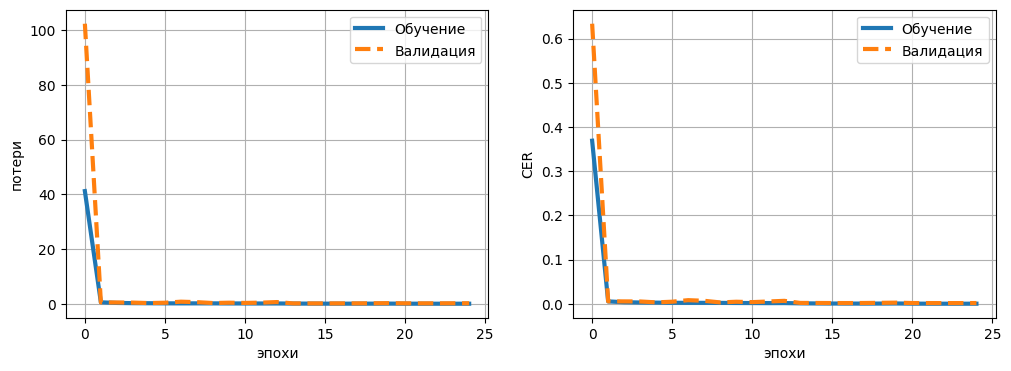

In [ ]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)

axes[0].plot(train_history['loss'], label="Обучение", linewidth = 3)
axes[0].plot(train_history['val_loss'], label="Валидация", linewidth = 3, linestyle = "dashed")
axes[0].set_xlabel("эпохи")
axes[0].set_ylabel("потери")
axes[0].grid()
axes[0].legend()

axes[1].plot(train_history['CER_metric'], label='Обучение', linewidth = 3)
axes[1].plot(train_history['val_CER_metric'], label='Валидация', linewidth = 3, linestyle = "dashed")
axes[1].set_xlabel("эпохи")
axes[1].set_ylabel("CER")
axes[1].grid()
axes[1].legend()

plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/OCR наброски/CRNN_model.h5', custom_objects={'CTCLoss' : CTCLoss, 'CERMetric': CERMetric})

In [ ]:
filesPath = "/content/drive/MyDrive/Colab Notebooks/OCR наброски"
test_X = np.load("%s/OCRdata/test_X.npy" % filesPath, allow_pickle=True)
test_y = np.load("%s/OCRdata/test_y.npy" % filesPath, allow_pickle=True)
with open("%s/OCRdata/alphabet.txt" % filesPath, 'r') as file:
    alphabet = file.read().replace('\n', '')

In [ ]:
model.evaluate(test_X, test_y)

90/90 [==============================] - 887s 10s/step - loss: 0.1206 - CER_metric: 0.0012


[0.12057755887508392, 0.0012068748474121094]

1/1 [==============================] - 0s 416ms/step
Исходник: фанфаристы коллагеновому разложившимся
Распознавание: ['фанфаристы коллагеновому разложившимся']


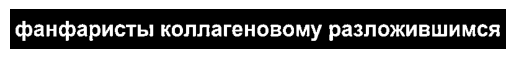

In [ ]:
indx = 597
predicts = model.predict(test_X[indx:indx+1])
predicts = decodeText(predicts)
plt.imshow(cv2.rotate(
      (test_X[indx]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
plt.axis('off')
print(f'Исходник: {numToLabel(test_y[indx], alphabet)}\nРаспознавание: {predicts}')